In [240]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5 #the derivative is 6x - 4

In [3]:
f(4.0)

37.0

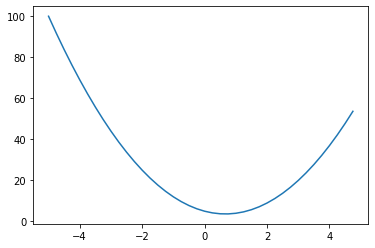

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.0001
x = 3.0 #the slope depends on the value of x
(f(x+h) - f(x)) / h #analytically 6 * 3 - 4 = 18 - 4 = 14

14.000300000063248

In [6]:
#more complex example

h = 0.001

#inputs
a = 2 
.0
b = -3.0
c = 10.0

d1 = a*b - c
c += h
d2 = a*b - c

slope = (d2 - d1)/h

print("d1", d1)
print("d2", d2)
print("slope w.r.t. the variable we changed", slope)

d1 -16.0
d2 -16.000999999999998
slope w.r.t. the variable we changed -0.9999999999976694


In [222]:
class Value:
  
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # 0 means no effect to the output
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad #accumulate all the gradient in case multiple uses of a value
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out
    
    
    def __rmul__(self, other): #reverse multiplication
        return self * other
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other),  '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
    
    def __radd__(self, other): #reverse addition
        return self + other
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __rsub__(self, other): #reverse substraction
        return other + (-self)
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __neg__(self): # -self
        return self * -1
    
    def __pow__(self, other): #no need to convert "other" into Value Class
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1.0 - (t)**2) * out.grad

        out._backward = _backward
        return out
        
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
            
        build_topo(self)
        
        self.grad = 1.0 #call the most right leaf to the backprop all the children
        for node in reversed(topo):
            node._backward()

In [8]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
b/2

Value(data=-1.5)

In [9]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [6]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        #dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

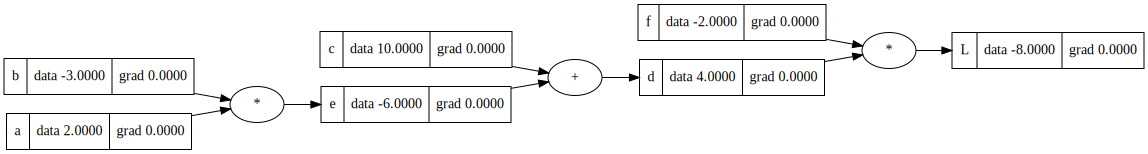

In [11]:
draw_dot(L)

In [65]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

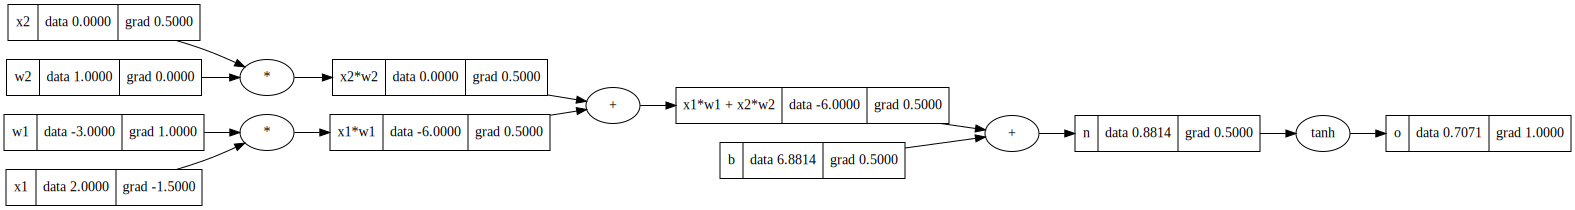

In [72]:
draw_dot(o)

In [70]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
    for child in v._prev:
        build_topo(child)
    topo.append(v)
build_topo(o)

topo


[Value(data=6.881373587019543),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [71]:
o.grad = 1.0
for node in reversed(topo):
    node._backward()

In [16]:
o._prev

{Value(data=0.8813735870195432)}

In [17]:
o.grad = 1.0 #initialize 

In [67]:
o._backward()

In [19]:
n._backward()

In [20]:
x1w1x2w2._backward()

In [21]:
x1w1._backward()

In [22]:
x2w2._backward()

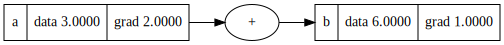

In [74]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

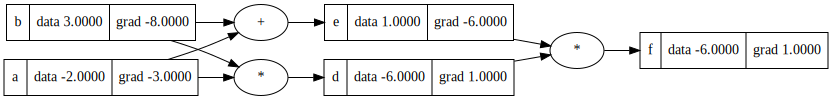

In [76]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

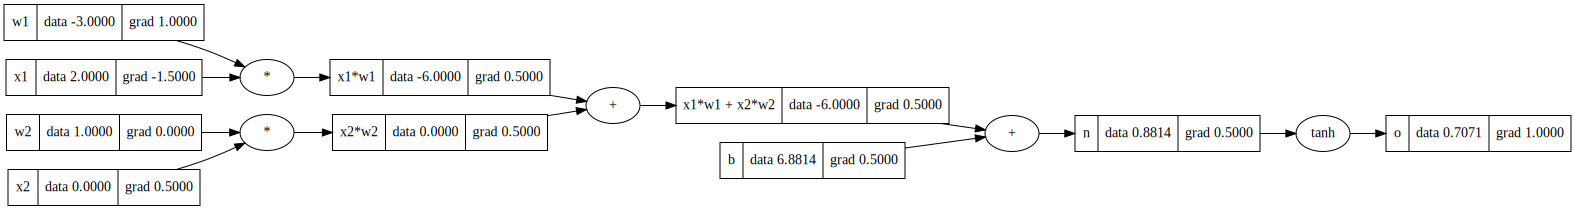

In [229]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

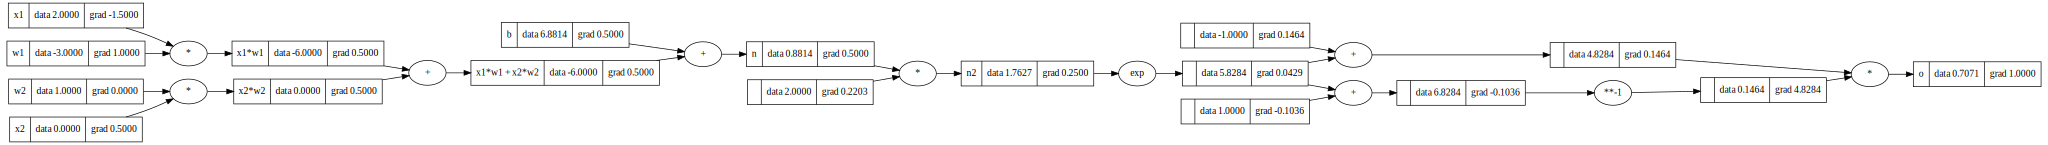

In [233]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
n2 = 2*n ; n2.label = 'n2'
e2 = n2.exp()
o = (e2 - 1) / (e2 + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [235]:
import torch

In [236]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [241]:
class Neuron:
  
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # a list of random number
        self.b = Value(random.uniform(-1,1)) # a scalar
  
    def __call__(self, x):
        '''
        Calculate the linear and activation function
        '''
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) #sum of (element-wise multiplication of w and x) and b
        out = act.tanh()
        return out
  
    def parameters(self):
        return self.w + [self.b] # a list of all parameter w and b in Neuron "self"

class Layer:
  
    def __init__(self, nin, nout):
        '''
        Build a layer of neurons with each neuron having nin number of input and nout number of output
        '''
        self.neurons = [Neuron(nin) for _ in range(nout)]  
  
    def __call__(self, x):
        '''
        Calculate every Neuron output in each the Layer
        '''
        outs = [n(x) for n in self.neurons] 
        return outs[0] if len(outs) == 1 else outs
  
    def parameters(self):
        '''
        Return a list of all parameter w and b in every Neuron in the Layer
        '''
        return [p for neuron in self.neurons for p in neuron.parameters()] 

class MLP:
  
    def __init__(self, nin, nouts):
        '''
        nin is the number of input, a scalar, e.g.: 3 -> 3 inputs
        nouts is a list of number of neurons in each layer, e.g. : [4, 1] -> 4 neurons in the 1st layer, 1 neuron in the 2nd layer
        '''
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
    def __call__(self, x):
        '''
        Calculate every Neuron output in every Layer
        '''
        for layer in self.layers:
            x = layer(x)
        return x
  
    def parameters(self):
        '''
        Return a list of all parameter w and b in every Neuron in every Layer
        '''
        return [p for layer in self.layers for p in layer.parameters()]

In [269]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1]) # an MPL with 3 inputs and 3 layers (2 hidden layers and an output layer)
n(x)

Value(data=0.2743429403450748)

In [270]:
# 4 training data points with 3 features
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

# 4 labels
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [304]:
for k in range(20):
    # forward prop
    ypred = [n(x) for x in xs] # predict every training data points

    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # Use sum of squared error for the loss function

    # backward pass
    for p in n.parameters(): # set all gradient to 0 because we use += operation
        p.grad = 0.0

    loss.backward()

    # update all parameter w and b
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 0.029509864546778845
1 0.02837209950181306
2 0.027314418614043722
3 0.026328841566457508
4 0.02540840039852498
5 0.024546985329728693
6 0.023739217743795366
7 0.02298034493864227
8 0.02226615243300126
9 0.02159289052217951
10 0.02095721246607245
11 0.02035612222561828
12 0.01978693007821553
13 0.019247214766822805
14 0.018734791092732295
15 0.018247682064218135
16 0.017784094874357136
17 0.01734240011035833
18 0.016921113700636484
19 0.01651888118993839


In [307]:
[n(x) for x in xs]

[Value(data=0.9483813169276292),
 Value(data=-0.9588886578611897),
 Value(data=-0.9182869634167405),
 Value(data=0.9285660251774858)]